In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from collections import defaultdict
from random import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from Agents import QAgent
from Environments import BraessParadoxEnv, BraessParadoxGymEnv
from visualization_tools import *

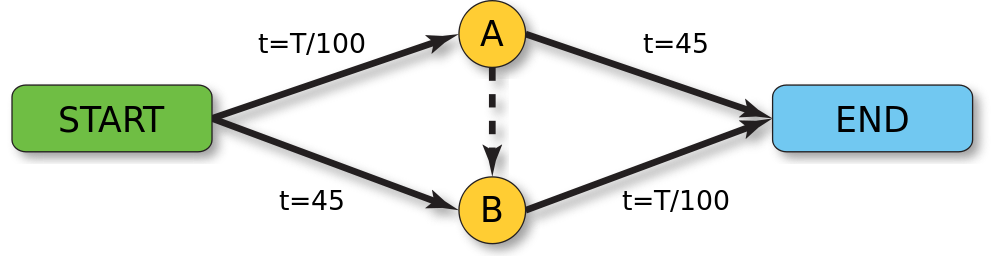

# Actions

In [3]:
import itertools

N = 400

#actions = {seq for seq in itertools.product("01", repeat=N)} (# too expensive)
from math import factorial

print(factorial(N)/factorial(N-2))

159600.0


In [4]:
from random import random

actions_sample = ['A' if random()>0.5 else 'B' for x in range(N)]
print(actions_sample[:10])

T = sum([a=='A' for a in actions_sample])
print(T)

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'A']
196


# Rewards

In [5]:
rewards = [T/100 if a=='A' else 45 for a in actions_sample]
print(rewards[:10])

[45, 45, 45, 45, 45, 45, 45, 1.96, 45, 1.96]


# States

In [6]:
states = {}
states['Start'] =  {'S': N, 'A': 0, 'B': 0, 'E': 0}

for t in range(N+1):
    states[str(t)] = {'S': 0, 'A': t, 'B': N - t, 'E': 0}

states['End'] = {'S': 0, 'A': 0, 'B': 0, 'E': N}

In [7]:
states[str(T)]

{'S': 0, 'A': 196, 'B': 204, 'E': 0}

In [8]:
states = {}
for i in range(N+1):
    for step in {0, 1}:
        for position in {'S', 'A', 'B'}:
            states[(position, step, i, N-i)] = 0.0

# Environment

In [14]:
env = BraessParadoxEnv(n_agents=400)
new_state = env.reset()

new_state['step'], new_state['actions'][0]

(0, 'S')

In [15]:
env = BraessParadoxGymEnv(n_agents=400)
new_state = env.reset()
new_state['step'], new_state['positions'][0]

(0, 0)

In [16]:
env.n_agents

400

In [17]:
env.social_welfare_type

'utilitarian'

In [18]:
env.cost_params

{'c1': -4.5, 'c2': -10.0}

In [19]:
sample_actions = ['A' if random() > 0.5 else 'B' for x in range(4000)]

new_state, rewards, done, info = env.step(sample_actions)

In [21]:
sample_actions[0], new_state['step'], new_state['positions'][0], rewards[0], done

('A', 1, 0, -45.0, False)

In [22]:
sample_actions = ['B' if (a == 'A') and (random() > 0.5) else a for a in sample_actions]

new_state, rewards, done, info = env.step(sample_actions)

In [25]:
sample_actions[0], new_state['step'], new_state['positions'][0], rewards[0], done

('A', 1, 0, 0.0, True)

In [32]:
env = BraessParadoxGymEnv(n_agents=400)
n_agents = env.n_agents
new_state = env.reset()

new_state['step'], new_state['positions'][0]

(0, 0)

In [33]:
params = {'lr': 0.005, 
          'gamma': 0.999, 
          'eps_start': 1.0, 
          'eps_end': 0.001,
          'eps_dec': 0.995}

In [34]:
agents = [QAgent(**params, id_agent=i) for i in tqdm(range(n_agents))]

  0%|          | 0/400 [00:00<?, ?it/s]

In [35]:
agents[0].choose_action(new_state)

1

In [36]:
actions = [agents[i].choose_action(new_state) for i in tqdm(range(env.n_agents))]
actions[0]

  0%|          | 0/400 [00:00<?, ?it/s]

0

In [37]:
new_state, rewards, done, info = env.step(actions)

In [39]:
new_state['positions'][0], rewards[0], done

(1, -11.641000000000043, False)

In [40]:
actions = [agents[i].choose_action(new_state) for i in tqdm(range(env.n_agents))]
actions[0]

  0%|          | 0/400 [00:00<?, ?it/s]

0

In [41]:
state = new_state
new_state, rewards, done, info = env.step(actions)

In [44]:
new_state['positions'][0]

3

In [47]:
def run_experiment(config, verbose=True):
    
    n_agents = config['n_agents']
    social_welfare_type = config['social_welfare_type']
    n_episodes = config['n_episodes']
    agent_params = config['agent_params']
    agent_type = config['agent_type']
    
    env = BraessParadoxGymEnv(n_agents=n_agents, social_welfare_type=social_welfare_type)
    
    agents = [eval(agent_type)(**agent_params, id_agent=i) for i in tqdm(range(n_agents))]

    # Intialization
    
    scores = defaultdict(list)
    win_pct_list = []
    cooperations = []
    qvalues = []
    actions_list = []

    for i_episode in tqdm(range(n_episodes)):


        actions_episode = []
        done = False
        state = env.reset()
        scores_episode = defaultdict(int)

        while not done:

            actions = [agents[i].choose_action(state) for i in range(n_agents)]
            new_state, rewards, done, info = env.step(actions)

            for id_agent in range(n_agents):
                agents[id_agent].learn(state, actions[id_agent], rewards[id_agent], new_state)
                scores_episode[id_agent] += rewards[id_agent]

            state = new_state
            actions_episode.append(actions)

        actions_list.append(actions_episode)

        qvalues.append(agents[0].Q)

        for id_agent in range(n_agents):
            scores[id_agent].append(scores_episode[id_agent])

        if verbose and i_episode % 100 == 0:

            mean_scores = [np.mean(scores[i][-100:]) for i in range(n_agents)]

            print('episode ', i_episode, 
                  '\n Mean Reward Agent 1 %.2f' % mean_scores[0],
                  '\n epsilon %.2f \n' % agents[0].epsilon,
                 '-'*100)
    
    report = {'scores': scores,
             'actions_list': actions_list,
             'qvalues': qvalues}
    return report

In [48]:
experiment_config = {
    'n_episodes': 1000,
    'n_agents': 400,
    'social_welfare_type': None,
    'agent_type': 'QAgent',
    'agent_params': {
        'lr': 0.005, 
        'gamma': 0.999, 
        'eps_start': 1.0, 
        'eps_end': 0.001,
        'eps_dec': 0.995
        }
   }

report = run_experiment(experiment_config)

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

episode  0 
 Mean Reward Agent 1 -33.50 
 epsilon 0.99 
 ----------------------------------------------------------------------------------------------------
episode  100 
 Mean Reward Agent 1 -45.44 
 epsilon 0.36 
 ----------------------------------------------------------------------------------------------------
episode  200 
 Mean Reward Agent 1 -63.31 
 epsilon 0.13 
 ----------------------------------------------------------------------------------------------------
episode  300 
 Mean Reward Agent 1 -73.10 
 epsilon 0.05 
 ----------------------------------------------------------------------------------------------------
episode  400 
 Mean Reward Agent 1 -76.00 
 epsilon 0.02 
 ----------------------------------------------------------------------------------------------------
episode  500 
 Mean Reward Agent 1 -79.19 
 epsilon 0.01 
 ----------------------------------------------------------------------------------------------------
episode  600 
 Mean Reward Agent 1 -79.81 

In [52]:
scores = report['scores']
actions_list = report['actions_list']

100


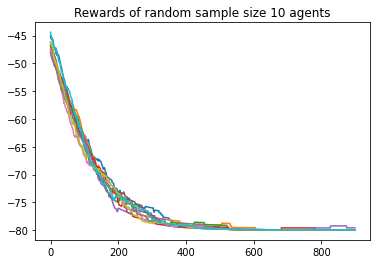

In [53]:
plot_scores(scores)

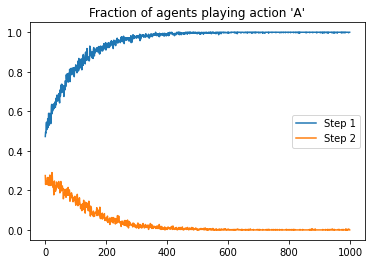

In [54]:
plot_actions(actions_list)